In [131]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn import neighbors, datasets, preprocessing
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

from bokeh.io import export_png, export_svgs
from bokeh.models import ColumnDataSource, DataTable, TableColumn

%matplotlib inline

In [2]:
moCoDetails = pd.read_csv("moCoDetails.csv", low_memory=False)

In [3]:
moCoDetails.columns

Index(['Unnamed: 0', 'Unnamed: 0_x', 'report_number', 'local_case_number_x',
       'agency_name_x', 'acrs_report_type_x', 'crash_date_time_x', 'hit_run',
       'route_type_x', 'mile_point',
       ...
       'pedestrian_actions', 'pedestrian_location',
       'pedestrian_obeyed_traffic_signal', 'pedestrian_visibility',
       'at_fault_y', 'injury_severity_y', 'safety_equipment', 'latitude',
       'longitude', 'location'],
      dtype='object', length=121)

In [4]:
moCoDetails['crash_date_time_x'] =pd.to_datetime(moCoDetails['crash_date_time_x'])


In [5]:
moCoDetails['year'] = pd.DatetimeIndex(moCoDetails['crash_date_time_x']).year.astype('Int64')
moCoDetails['month'] = pd.DatetimeIndex(moCoDetails['crash_date_time_x']).month.astype('Int64')
moCoDetails['month_year'] = pd.to_datetime(moCoDetails['crash_date_time_x']).dt.to_period('M')
moCoDetails['weekday'] = moCoDetails['crash_date_time_x'].dt.day_name()
moCoDetails['time'] = moCoDetails['crash_date_time_x'].dt.time
moCoDetails['hour'] = moCoDetails['crash_date_time_x'].dt.hour.astype('Int64')
moCoDetails[['year', 'month', 'weekday', 'time', 'hour']]

,year,month,weekday,time,hour
0,2020,5,Saturday,14:16:00,14
1,2020,9,Tuesday,15:33:00,15
2,2020,9,Tuesday,15:33:00,15
3,2020,10,Wednesday,08:40:00,8
4,2020,3,Tuesday,09:19:00,9
...,...,...,...,...,...
122554,2021,3,Monday,14:15:00,14
122555,2021,3,Monday,14:15:00,14
122556,2021,3,Monday,14:15:00,14
122557,2021,3,Wednesday,21:15:00,21


In [6]:
# Pull out the columns I'm interested in exploring for relationships

analysisDF = moCoDetails[['year', 'month', 'month_year', 'weekday', 'hour', 'acrs_report_type', 'number_of_lanes', 
                         'municipality','related_non_motorist', 'weather','surface_condition','light', 
                         'driver_substance_abuse','non_motorist_substance_abuse', 'pedestrian_type','pedestrian_movement'
                          ,'pedestrian_actions', 'pedestrian_obeyed_traffic_signal','pedestrian_visibility','driver_distracted_by', 'injury_severity_x', 
                         'injury_severity_y']]

In [7]:
analysisDF.columns

Index(['year', 'month', 'month_year', 'weekday', 'hour', 'acrs_report_type',
       'number_of_lanes', 'municipality', 'related_non_motorist', 'weather',
       'surface_condition', 'light', 'driver_substance_abuse',
       'non_motorist_substance_abuse', 'pedestrian_type',
       'pedestrian_movement', 'pedestrian_actions',
       'pedestrian_obeyed_traffic_signal', 'pedestrian_visibility',
       'driver_distracted_by', 'injury_severity_x', 'injury_severity_y'],
      dtype='object')

In [8]:
analysisDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122559 entries, 0 to 122558
Data columns (total 22 columns):
 #   Column                            Non-Null Count   Dtype    
---  ------                            --------------   -----    
 0   year                              122558 non-null  object   
 1   month                             122558 non-null  object   
 2   month_year                        122558 non-null  period[M]
 3   weekday                           122558 non-null  object   
 4   hour                              122558 non-null  Int64    
 5   acrs_report_type                  4053 non-null    object   
 6   number_of_lanes                   122558 non-null  float64  
 7   municipality                      4053 non-null    object   
 8   related_non_motorist              4053 non-null    object   
 9   weather                           3682 non-null    object   
 10  surface_condition                 4053 non-null    object   
 11  light                     

In [9]:
# Y must be from the related-non-motorist dataset -- I'm going to go back to the merge and clean this up
pd.crosstab(moCoDetails.injury_severity_y, moCoDetails.speed_limit)

speed_limit,0.0,5.0,10.0,15.0,20.0,25.0,30.0,35.0,40.0,45.0,50.0,55.0
injury_severity_y,,,,,,,,,,,,
FATAL INJURY,1,0,0,1,0,8,13,21,32,11,4,0
NO APPARENT INJURY,19,27,12,39,3,118,44,77,26,9,1,3
POSSIBLE INJURY,86,97,67,126,16,321,175,272,95,56,10,2
SUSPECTED MINOR INJURY,91,101,73,165,18,423,259,355,174,65,16,2
SUSPECTED SERIOUS INJURY,15,13,10,23,4,89,59,114,70,30,11,3


In [10]:
# X must be from the drivers dataset
pd.crosstab(moCoDetails.injury_severity_x, moCoDetails.speed_limit)

speed_limit,0.0,5.0,10.0,15.0,20.0,25.0,30.0,35.0,40.0,45.0,50.0,55.0,60.0,65.0,70.0
injury_severity_x,,,,,,,,,,,,,,,
FATAL INJURY,1,0,0,0,0,8,13,11,32,10,19,0,0,0,0
NO APPARENT INJURY,3074,2599,1972,4044,648,14383,13517,27511,19600,7201,2632,2308,39,43,2
POSSIBLE INJURY,142,88,61,175,45,1277,1716,3808,3223,1227,475,315,1,2,0
SUSPECTED MINOR INJURY,89,49,65,103,30,986,1288,2554,2216,853,379,219,7,4,0
SUSPECTED SERIOUS INJURY,10,6,5,5,6,87,141,275,293,111,61,33,1,1,0


In [11]:
# Null hypothesis is that speed limit has no relationship to severity of injuries

chi2_contingency(pd.crosstab(moCoDetails.injury_severity_y, moCoDetails.speed_limit))

(225.55582540774543,
 3.147517767425494e-26,
 44,
 array([[4.85333333e+00, 5.44855346e+00, 3.70867925e+00, 8.10415094e+00,
         9.38616352e-01, 2.19544654e+01, 1.25911950e+01, 1.92072956e+01,
         9.08855346e+00, 3.91471698e+00, 9.61509434e-01, 2.28930818e-01],
        [2.01600000e+01, 2.26324528e+01, 1.54052830e+01, 3.36633962e+01,
         3.89886792e+00, 9.11954717e+01, 5.23018868e+01, 7.97841509e+01,
         3.77524528e+01, 1.62611321e+01, 3.99396226e+00, 9.50943396e-01],
        [7.05600000e+01, 7.92135849e+01, 5.39184906e+01, 1.17821887e+02,
         1.36460377e+01, 3.19184151e+02, 1.83056604e+02, 2.79244528e+02,
         1.32133585e+02, 5.69139623e+01, 1.39788679e+01, 3.32830189e+00],
        [9.29066667e+01, 1.04300881e+02, 7.09947170e+01, 1.55136604e+02,
         1.79677987e+01, 4.20271195e+02, 2.41031447e+02, 3.67682516e+02,
         1.73980881e+02, 7.49388679e+01, 1.84060377e+01, 4.38238994e+00],
        [2.35200000e+01, 2.64045283e+01, 1.79728302e+01, 3.92739623e+0

The p-score is 3.1475e-26, which is very low, and indicates we can reject the null hypothesis.  In other words, the speed limit has a relationship to the severity of the injury in non-motorist collisions.

In [12]:
# Null hypothesis is that speed limit has no relationship to severity of injuries

chi2_contingency(pd.crosstab(moCoDetails.injury_severity_x, moCoDetails.speed_limit))

(2242.224660990909,
 0.0,
 56,
 array([[2.55287922e+00, 2.11097552e+00, 1.61903046e+00, 3.33121483e+00,
         5.61233098e-01, 1.28883447e+01, 1.28375335e+01, 2.62978894e+01,
         1.95269085e+01, 7.23829024e+00, 2.74534599e+00, 2.21336784e+00,
         3.69536196e-02, 3.84933538e-02, 1.53973415e-03],
        [2.70423237e+03, 2.23612942e+03, 1.71501830e+03, 3.52871335e+03,
         5.94507056e+02, 1.36524590e+04, 1.35986353e+04, 2.78570185e+04,
         2.06846049e+04, 7.66742845e+03, 2.90810996e+03, 2.34459230e+03,
         3.91444975e+01, 4.07755182e+01, 1.63102073e+00],
        [3.40972326e+02, 2.81949975e+02, 2.16243909e+02, 4.44929811e+02,
         7.49604419e+01, 1.72141668e+03, 1.71463014e+03, 3.51244683e+03,
         2.60808868e+03, 9.66773766e+02, 3.66678924e+02, 2.95625886e+02,
         4.93566696e+00, 5.14131975e+00, 2.05652790e-01],
        [2.40133597e+02, 1.98566442e+02, 1.52292206e+02, 3.13346825e+02,
         5.27917346e+01, 1.21232706e+03, 1.20754756e+03, 2.473680

The p-score is 0, which is very low, and indicates we can reject the null hypothesis. In other words, the speed limit has a relationship to the severity of the injury in motorist collisions.

In [13]:
pd.crosstab(moCoDetails.injury_severity_y, moCoDetails.number_of_lanes)

number_of_lanes,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0
injury_severity_y,,,,,,,,
FATAL INJURY,4,7,25,40,4,5,7,0
NO APPARENT INJURY,98,116,105,53,16,0,3,0
POSSIBLE INJURY,353,319,346,258,41,10,18,0
SUSPECTED MINOR INJURY,409,414,533,302,78,20,21,1
SUSPECTED SERIOUS INJURY,62,78,131,127,32,9,8,0


In [14]:
# There are no zero lane roads, so we will drop that for our analysis

zeroLanes = moCoDetails['number_of_lanes'] != 0.0
laneNumbers = moCoDetails[zeroLanes]
pd.crosstab(laneNumbers.injury_severity_y, laneNumbers.number_of_lanes)

number_of_lanes,1.0,2.0,3.0,4.0,5.0,6.0,7.0
injury_severity_y,,,,,,,
FATAL INJURY,7,25,40,4,5,7,0
NO APPARENT INJURY,116,105,53,16,0,3,0
POSSIBLE INJURY,319,346,258,41,10,18,0
SUSPECTED MINOR INJURY,414,533,302,78,20,21,1
SUSPECTED SERIOUS INJURY,78,131,127,32,9,8,0


In [15]:
pd.crosstab(laneNumbers.injury_severity_x, laneNumbers.number_of_lanes)

number_of_lanes,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
injury_severity_x,,,,,,,,,,,,,
FATAL INJURY,26,35,23,6,0,2,1,0,0,1,0,0,0
NO APPARENT INJURY,17653,28859,30760,7708,1625,1612,189,90,11,6,2,3,4
POSSIBLE INJURY,2132,3913,4578,1045,218,217,26,13,1,0,0,0,0
SUSPECTED MINOR INJURY,1514,2955,2960,797,160,149,24,7,2,2,0,1,0
SUSPECTED SERIOUS INJURY,204,351,313,79,15,27,6,3,1,0,0,0,0


In [16]:
# Null hypothesis is that number of lanes has no relationship to severity of injuries

chi2_contingency(pd.crosstab(laneNumbers.injury_severity_y, laneNumbers.number_of_lanes))

(127.17610210917115,
 5.02196058266101e-16,
 24,
 array([[2.62846178e+01, 3.20818676e+01, 2.19507515e+01, 4.81228014e+00,
         1.23824752e+00, 1.60409338e+00, 2.81419891e-02],
        [8.75158299e+01, 1.06818036e+02, 7.30860249e+01, 1.60227055e+01,
         4.12280141e+00, 5.34090182e+00, 9.37000320e-02],
        [2.96299328e+02, 3.61650144e+02, 2.47444835e+02, 5.42475216e+01,
         1.39584266e+01, 1.80825072e+01, 3.17236968e-01],
        [4.08905021e+02, 4.99091781e+02, 3.41483850e+02, 7.48637672e+01,
         1.92631916e+01, 2.49545891e+01, 4.37799808e-01],
        [1.14995203e+02, 1.40358171e+02, 9.60345379e+01, 2.10537256e+01,
         5.41733291e+00, 7.01790854e+00, 1.23121202e-01]]))

This too has a very low p-number, so the number of lanes probably has a relationship with the severity of injuries.  (It probably has a relationship with the speed limit as well.). We can do a chi-squared test on that too to see.


In [17]:
# Null hypothesis is that number of lanes has no relationship to speed limit

chi2_contingency(pd.crosstab(laneNumbers.speed_limit, laneNumbers.number_of_lanes))

(26370.765167728292,
 0.0,
 168,
 array([[9.81526797e+01, 1.64642469e+02, 1.76135939e+02, 4.39268461e+01,
         9.20024654e+00, 9.15009653e+00, 1.12153650e+00, 5.15177333e-01,
         6.83863717e-02, 4.10318230e-02, 9.11818289e-03, 1.82363658e-02,
         1.82363658e-02],
        [5.99063075e+01, 1.00487551e+02, 1.07502452e+02, 2.68102222e+01,
         5.61525981e+00, 5.58465136e+00, 6.84516310e-01, 3.14432289e-01,
         4.17387994e-02, 2.50432796e-02, 5.56517325e-03, 1.11303465e-02,
         1.11303465e-02],
        [7.68830135e+01, 1.28964479e+02, 1.37967316e+02, 3.44079073e+01,
         7.20655494e+00, 7.16727243e+00, 8.78499760e-01, 4.03538508e-01,
         5.35670585e-02, 3.21402351e-02, 7.14227447e-03, 1.42845489e-02,
         1.42845489e-02],
        [2.60699762e+02, 4.37300873e+02, 4.67828259e+02, 1.16672498e+02,
         2.44364401e+01, 2.43032385e+01, 2.97887228e+00, 1.36834377e+00,
         1.81638554e-01, 1.08983132e-01, 2.42184738e-02, 4.84369477e-02,
         4.84

This has a p-score of zero, so it is very probable there is a relationship between speed limit and number of lanes. 

In [18]:
#sns.pairplot(moCoDetails, hue = "injury_severity_y", height = 2.5)

## Comparing Montgomery County with Maryland, Prince George's, and Frederick Counties, and the District of Columbia

In [19]:
# Construct a data frame of crashes and population data

crashDataMD = pd.read_csv('crash_data_pop_data.csv')

In [20]:
crashDataMD

,year,fatal_crashes,serious_injury_crashes,location,population
0,2015,518,2630,Maryland,6006401
1,2015,46,341,Montgomery County,1040116
2,2015,22,69,Frederick County,245322
3,2015,93,455,Prince George's County,909535
4,2016,459,3084,Maryland,6016447
5,2016,39,334,Montgomery County,1043863
6,2016,14,69,Frederick County,247591
7,2016,70,554,Prince George's County,908049
8,2017,498,3230,Maryland,6052177
9,2017,33,324,Montgomery County,1058810


In [21]:
dropMaryland = crashDataMD['location'] != 'Maryland'
crashData = crashDataMD[dropMaryland]
crashData

,year,fatal_crashes,serious_injury_crashes,location,population
1,2015,46,341,Montgomery County,1040116
2,2015,22,69,Frederick County,245322
3,2015,93,455,Prince George's County,909535
5,2016,39,334,Montgomery County,1043863
6,2016,14,69,Frederick County,247591
7,2016,70,554,Prince George's County,908049
9,2017,33,324,Montgomery County,1058810
10,2017,26,87,Frederick County,252022
11,2017,80,554,Prince George's County,912756
13,2018,31,312,Montgomery County,1052567


In [22]:
sns.set_style('whitegrid')

(array([4., 3., 4., 1., 0., 0., 1., 1., 2., 2.]),
 array([ 14. ,  23.3,  32.6,  41.9,  51.2,  60.5,  69.8,  79.1,  88.4,
         97.7, 107. ]),
 <BarContainer object of 10 artists>)

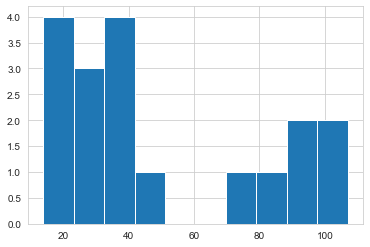

In [23]:
plt.hist(crashData['fatal_crashes'])

<AxesSubplot:xlabel='fatal_crashes', ylabel='Count'>

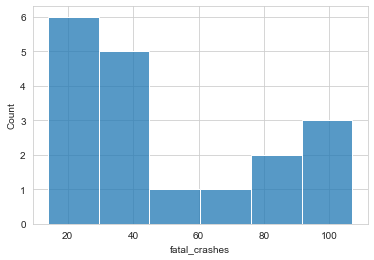

In [24]:
sns.histplot(crashData.fatal_crashes)

Text(0.5, 0, 'Year\n\nSource: https://data.montgomerycountymd.gov/Public-Safety/Crash-Reporting-Incidents-Data/bhju-22kf')

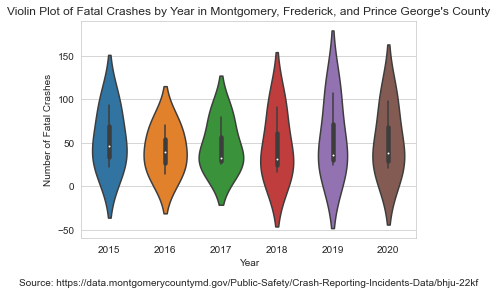

In [25]:
sns.violinplot(x='year', y='fatal_crashes', data=crashData)
plt.title("Violin Plot of Fatal Crashes by Year in Montgomery, Frederick, and Prince George's County")
plt.ylabel('Number of Fatal Crashes')
plt.xlabel("Year\n\nSource: https://data.montgomerycountymd.gov/Public-Safety/Crash-Reporting-Incidents-Data/bhju-22kf")



Text(0.5, 0, 'Year')

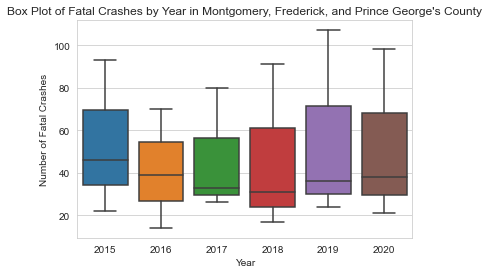

In [26]:
sns.boxplot(x='year', y='fatal_crashes', data=crashData)
plt.title("Box Plot of Fatal Crashes by Year in Montgomery, Frederick, and Prince George's County")
plt.ylabel('Number of Fatal Crashes')
plt.xlabel('Year')

(array([1., 1., 0., 1., 1., 1., 0., 0., 0., 1.]),
 array([31. , 32.5, 34. , 35.5, 37. , 38.5, 40. , 41.5, 43. , 44.5, 46. ]),
 <BarContainer object of 10 artists>)

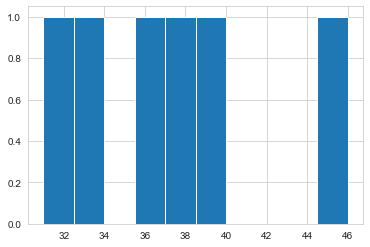

In [27]:
montCo = crashData['location'] == 'Montgomery County'
moCoCrashes = crashData[montCo]
plt.hist(moCoCrashes['fatal_crashes'])

<AxesSubplot:xlabel='fatal_crashes', ylabel='Count'>

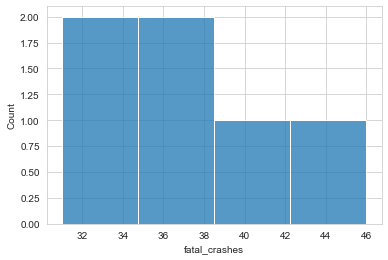

In [28]:
sns.histplot(moCoCrashes.fatal_crashes)

Text(0.5, 0, 'Year')

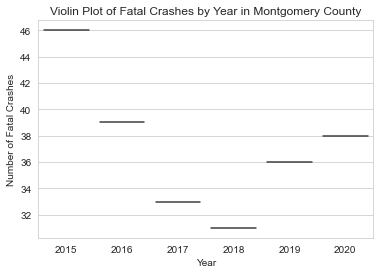

In [29]:
sns.violinplot(x='year', y='fatal_crashes', data=moCoCrashes)
plt.title('Violin Plot of Fatal Crashes by Year in Montgomery County')
plt.ylabel('Number of Fatal Crashes')
plt.xlabel('Year')

Text(0.5, 0, 'Year')

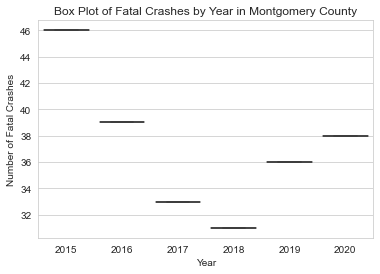

In [30]:
sns.boxplot(x='year', y='fatal_crashes', data=moCoCrashes)
plt.title('Box Plot of Fatal Crashes by Year in Montgomery County')
plt.ylabel('Number of Fatal Crashes')
plt.xlabel('Year')

(array([1., 0., 1., 0., 0., 1., 1., 0., 1., 1.]),
 array([14. , 15.2, 16.4, 17.6, 18.8, 20. , 21.2, 22.4, 23.6, 24.8, 26. ]),
 <BarContainer object of 10 artists>)

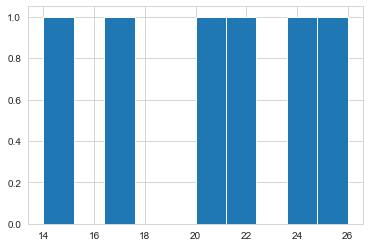

In [31]:
fredCo = crashData['location'] == 'Frederick County'
fredCoCrashes = crashData[fredCo]
plt.hist(fredCoCrashes['fatal_crashes'])

Text(0.5, 0, 'Year')

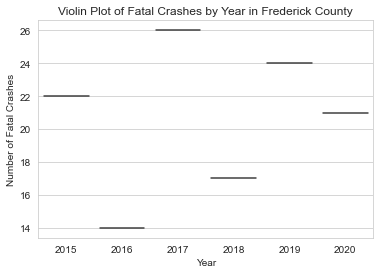

In [32]:
sns.violinplot(x='year', y='fatal_crashes', data=fredCoCrashes)
plt.title('Violin Plot of Fatal Crashes by Year in Frederick County')
plt.ylabel('Number of Fatal Crashes')
plt.xlabel('Year')

Text(0.5, 0, 'Year')

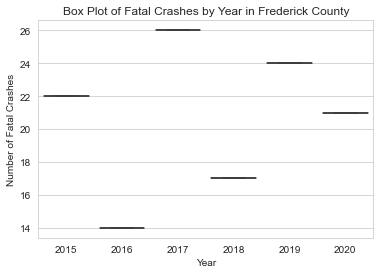

In [33]:
sns.boxplot(x='year', y='fatal_crashes', data=fredCoCrashes)
plt.title('Box Plot of Fatal Crashes by Year in Frederick County')
plt.ylabel('Number of Fatal Crashes')
plt.xlabel('Year')

(array([1., 0., 1., 0., 0., 1., 1., 1., 0., 1.]),
 array([ 70. ,  73.7,  77.4,  81.1,  84.8,  88.5,  92.2,  95.9,  99.6,
        103.3, 107. ]),
 <BarContainer object of 10 artists>)

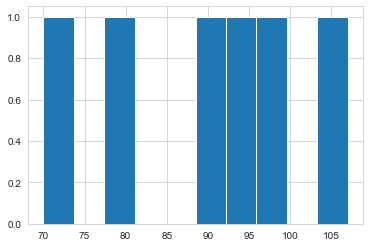

In [34]:
pgCo = crashData['location'] == "Prince George's County"
pgCoCrashes = crashData[pgCo]
plt.hist(pgCoCrashes['fatal_crashes'])

Text(0.5, 0, 'Year')

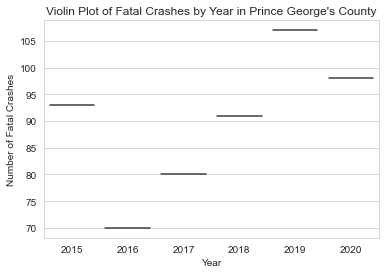

In [35]:
sns.violinplot(x='year', y='fatal_crashes', data= pgCoCrashes)
plt.title("Violin Plot of Fatal Crashes by Year in Prince George's County")
plt.ylabel('Number of Fatal Crashes')
plt.xlabel('Year')

Text(0.5, 0, 'Year')

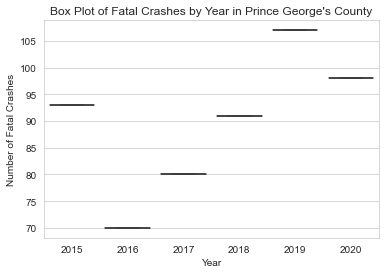

In [36]:
sns.boxplot(x='year', y='fatal_crashes', data=pgCoCrashes)
plt.title("Box Plot of Fatal Crashes by Year in Prince George's County")
plt.ylabel('Number of Fatal Crashes')
plt.xlabel('Year')

(array([6., 0., 1., 0., 2., 4., 0., 1., 1., 3.]),
 array([ 69. , 118.8, 168.6, 218.4, 268.2, 318. , 367.8, 417.6, 467.4,
        517.2, 567. ]),
 <BarContainer object of 10 artists>)

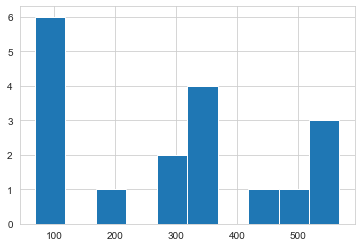

In [37]:
plt.hist(crashData['serious_injury_crashes'])

Text(0.5, 0, 'Year\n\nSource: https://data.montgomerycountymd.gov/Public-Safety/Crash-Reporting-Incidents-Data/bhju-22kf')

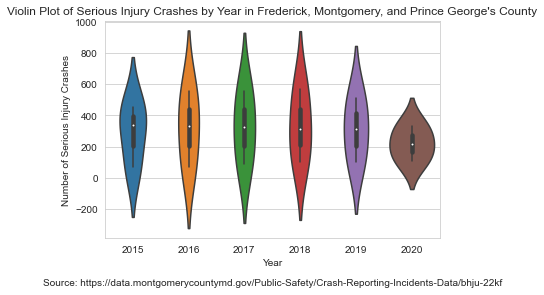

In [38]:
sns.violinplot(x='year', y='serious_injury_crashes', data=crashData)
plt.title("Violin Plot of Serious Injury Crashes by Year in Frederick, Montgomery, and Prince George's County")
plt.ylabel('Number of Serious Injury Crashes')
plt.xlabel("Year\n\nSource: https://data.montgomerycountymd.gov/Public-Safety/Crash-Reporting-Incidents-Data/bhju-22kf")



Text(0.5, 0, 'Year')

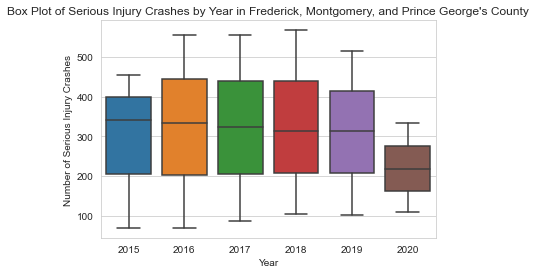

In [39]:
sns.boxplot(x='year', y='serious_injury_crashes', data=crashData)
plt.title("Box Plot of Serious Injury Crashes by Year in Frederick, Montgomery, and Prince George's County")
plt.ylabel('Number of Serious Injury Crashes')
plt.xlabel('Year')

(array([1., 0., 0., 0., 0., 0., 0., 2., 1., 2.]),
 array([217. , 229.4, 241.8, 254.2, 266.6, 279. , 291.4, 303.8, 316.2,
        328.6, 341. ]),
 <BarContainer object of 10 artists>)

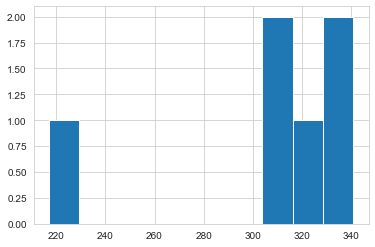

In [40]:
plt.hist(moCoCrashes['serious_injury_crashes'])

Text(0.5, 0, 'Year')

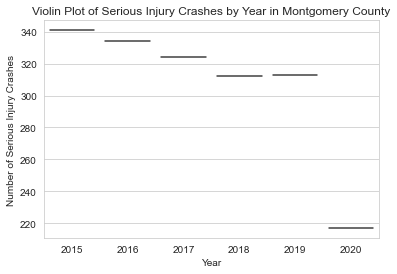

In [41]:
sns.violinplot(x='year', y='serious_injury_crashes', data=moCoCrashes)
plt.title("Violin Plot of Serious Injury Crashes by Year in Montgomery County")
plt.ylabel('Number of Serious Injury Crashes')
plt.xlabel('Year')

Text(0.5, 0, 'Year')

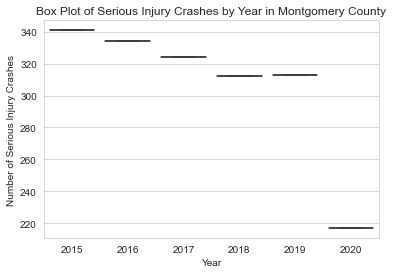

In [42]:
sns.boxplot(x='year', y='serious_injury_crashes', data=moCoCrashes)
plt.title("Box Plot of Serious Injury Crashes by Year in Montgomery County")
plt.ylabel('Number of Serious Injury Crashes')
plt.xlabel('Year')

(array([2., 0., 0., 0., 1., 0., 0., 0., 2., 1.]),
 array([ 69.,  73.,  77.,  81.,  85.,  89.,  93.,  97., 101., 105., 109.]),
 <BarContainer object of 10 artists>)

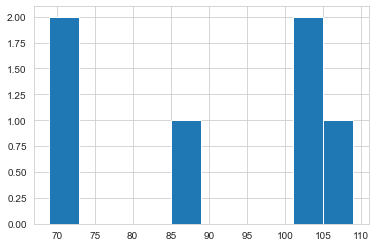

In [43]:
plt.hist(fredCoCrashes['serious_injury_crashes'])

Text(0.5, 0, 'Year')

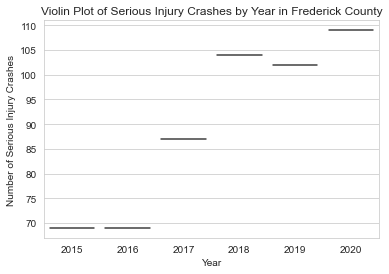

In [44]:
sns.violinplot(x='year', y='serious_injury_crashes', data=fredCoCrashes)
plt.title("Violin Plot of Serious Injury Crashes by Year in Frederick County")
plt.ylabel('Number of Serious Injury Crashes')
plt.xlabel('Year')

Text(0.5, 0, 'Year')

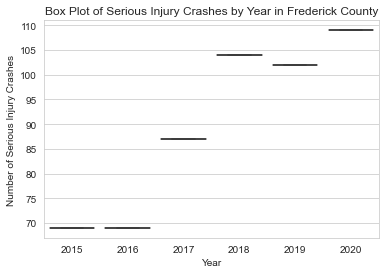

In [45]:
sns.boxplot(x='year', y='serious_injury_crashes', data=fredCoCrashes)
plt.title("Box Plot of Serious Injury Crashes by Year in Frederick County")
plt.ylabel('Number of Serious Injury Crashes')
plt.xlabel('Year')

(array([1., 0., 0., 0., 0., 1., 0., 1., 0., 3.]),
 array([333. , 356.4, 379.8, 403.2, 426.6, 450. , 473.4, 496.8, 520.2,
        543.6, 567. ]),
 <BarContainer object of 10 artists>)

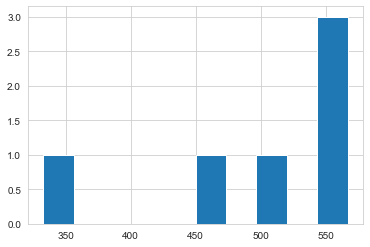

In [46]:
plt.hist(pgCoCrashes['serious_injury_crashes'])

Text(0.5, 0, 'Year')

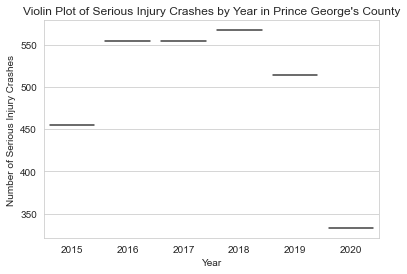

In [47]:
sns.violinplot(x='year', y='serious_injury_crashes', data=pgCoCrashes)
plt.title("Violin Plot of Serious Injury Crashes by Year in Prince George's County")
plt.ylabel('Number of Serious Injury Crashes')
plt.xlabel('Year')

Text(0.5, 0, 'Year')

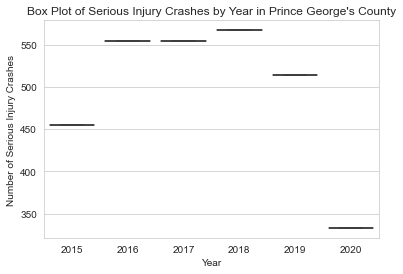

In [48]:
sns.boxplot(x='year', y='serious_injury_crashes', data=pgCoCrashes)
plt.title("Box Plot of Serious Injury Crashes by Year in Prince George's County")
plt.ylabel('Number of Serious Injury Crashes')
plt.xlabel('Year')

### One way ANOVA using statsmodels

In [49]:
modelFatalities = ols(' fatal_crashes ~ C(location) ', data= crashData).fit()
aov_table = sm.stats.anova_lm(modelFatalities, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
C(location),15660.111111,2.0,106.676506,1.352489e-09
Residual,1101.000000,15.0,NaN,NaN


In [50]:
# source:  https://www.pythonfordatascience.org/anova-python/

"""
The function below was created specifically for the one-way ANOVA table results returned for Type II sum of squares
"""

def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']

    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])

    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])

    cols = ['sum_sq', 'df', 'mean_sq', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

anova_table(aov_table)

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
C(location),15660.111111,2.0,7830.055556,106.676506,1.352489e-09,0.934312,0.921518
Residual,1101.000000,15.0,73.400000,NaN,NaN,NaN,NaN


In [51]:
modelInjuries = ols('serious_injury_crashes ~ C(location)', data = crashData).fit()
aov_table1 = sm.stats.anova_lm(modelInjuries, typ= 2)
aov_table1

,sum_sq,df,F,PR(>F)
C(location),495670.333333,2.0,71.122082,2.220115e-08
Residual,52269.666667,15.0,NaN,NaN


In [52]:
anova_table(aov_table1)

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
C(location),495670.333333,2.0,247835.166667,71.122082,2.220115e-08,0.904607,0.886252
Residual,52269.666667,15.0,3484.644444,NaN,NaN,NaN,NaN


## Import traffic volumes for Montgomery, Prince George's, and Frederick County

source(https://hub.arcgis.com/datasets/maryland::maryland-annual-average-daily-traffic-annual-average-daily-traffic-sha-statewide-aadt-points)

In [53]:
trafficVols = pd.read_csv("trafficVols.csv")

### Build table with crashes, fatalities, serious injuries, and traffic volumes by county

Use Maryland, as opposed to Montgomery County, data for consistency.  (Different counting methods at county and state level.)

In [54]:
crashData.head()

,year,fatal_crashes,serious_injury_crashes,location,population
1,2015,46,341,Montgomery County,1040116
2,2015,22,69,Frederick County,245322
3,2015,93,455,Prince George's County,909535
5,2016,39,334,Montgomery County,1043863
6,2016,14,69,Frederick County,247591


In [55]:
crashData

,year,fatal_crashes,serious_injury_crashes,location,population
1,2015,46,341,Montgomery County,1040116
2,2015,22,69,Frederick County,245322
3,2015,93,455,Prince George's County,909535
5,2016,39,334,Montgomery County,1043863
6,2016,14,69,Frederick County,247591
7,2016,70,554,Prince George's County,908049
9,2017,33,324,Montgomery County,1058810
10,2017,26,87,Frederick County,252022
11,2017,80,554,Prince George's County,912756
13,2018,31,312,Montgomery County,1052567


In [56]:
trafficVols

,COUNTY_DESC,AADT_2015,AADT_2016,AADT_2017,AADT_2018
0,Frederick,119182.0,116330.0,119121.0,118052.0
1,Montgomery,255600.0,260971.0,267232.0,265633.0
2,Prince George's,252835.0,247970.0,253921.0,252402.0


In [57]:
trafficVols.rename({'COUNTY_DESC': 'location', 'AADT_2015': '2015', 'AADT_2016': '2016', 'AADT_2017': '2017', 'AADT_2018':'2018'}, 
                   axis=1, inplace = True)
trafficVols.head()

,location,2015,2016,2017,2018
0,Frederick,119182.0,116330.0,119121.0,118052.0
1,Montgomery,255600.0,260971.0,267232.0,265633.0
2,Prince George's,252835.0,247970.0,253921.0,252402.0


In [58]:
trafficVols

,location,2015,2016,2017,2018
0,Frederick,119182.0,116330.0,119121.0,118052.0
1,Montgomery,255600.0,260971.0,267232.0,265633.0
2,Prince George's,252835.0,247970.0,253921.0,252402.0


In [59]:
trafficVols = trafficVols.melt(id_vars='location')

In [60]:
trafficVols.head()

,location,variable,value
0,Frederick,2015,119182.0
1,Montgomery,2015,255600.0
2,Prince George's,2015,252835.0
3,Frederick,2016,116330.0
4,Montgomery,2016,260971.0


In [61]:
trafficVols.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   location  12 non-null     object 
 1   variable  12 non-null     object 
 2   value     12 non-null     float64
dtypes: float64(1), object(2)
memory usage: 416.0+ bytes


In [62]:
trafficVols.rename({'variable': 'year', 'value': 'traffic_volume'}, axis = 1, inplace = True)
trafficVols

,location,year,traffic_volume
0,Frederick,2015,119182.0
1,Montgomery,2015,255600.0
2,Prince George's,2015,252835.0
3,Frederick,2016,116330.0
4,Montgomery,2016,260971.0
5,Prince George's,2016,247970.0
6,Frederick,2017,119121.0
7,Montgomery,2017,267232.0
8,Prince George's,2017,253921.0
9,Frederick,2018,118052.0


In [63]:
trafficVols['location'] = trafficVols['location'].replace(['Frederick', 'Montgomery', "Prince George's"],
                                                          ['Frederick County', 'Montgomery County', 
                                                           "Prince George's County"])

In [64]:
trafficVols['year'] = trafficVols['year'].astype(int)


In [65]:
trafficVols.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   location        12 non-null     object 
 1   year            12 non-null     int64  
 2   traffic_volume  12 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 416.0+ bytes


In [66]:
trafficData  = pd.merge(crashData, trafficVols, on=['location', 'year'], how='inner')

In [67]:
trafficData

,year,fatal_crashes,serious_injury_crashes,location,population,traffic_volume
0,2015,46,341,Montgomery County,1040116,255600.0
1,2015,22,69,Frederick County,245322,119182.0
2,2015,93,455,Prince George's County,909535,252835.0
3,2016,39,334,Montgomery County,1043863,260971.0
4,2016,14,69,Frederick County,247591,116330.0
5,2016,70,554,Prince George's County,908049,247970.0
6,2017,33,324,Montgomery County,1058810,267232.0
7,2017,26,87,Frederick County,252022,119121.0
8,2017,80,554,Prince George's County,912756,253921.0
9,2018,31,312,Montgomery County,1052567,265633.0


#### Note:  We only have traffic volume data up to 2018, so our new dataframe only covers up until that period

In [68]:
trafficData['fatalCrashesbyVolume'] = trafficData['fatal_crashes']/trafficData['traffic_volume']

In [69]:
trafficData

,year,fatal_crashes,serious_injury_crashes,location,population,traffic_volume,fatalCrashesbyVolume
0,2015,46,341,Montgomery County,1040116,255600.0,0.000180
1,2015,22,69,Frederick County,245322,119182.0,0.000185
2,2015,93,455,Prince George's County,909535,252835.0,0.000368
3,2016,39,334,Montgomery County,1043863,260971.0,0.000149
4,2016,14,69,Frederick County,247591,116330.0,0.000120
5,2016,70,554,Prince George's County,908049,247970.0,0.000282
6,2017,33,324,Montgomery County,1058810,267232.0,0.000123
7,2017,26,87,Frederick County,252022,119121.0,0.000218
8,2017,80,554,Prince George's County,912756,253921.0,0.000315
9,2018,31,312,Montgomery County,1052567,265633.0,0.000117


In [70]:
trafficData['seriousInjuryCrashesbyVolume'] = trafficData['serious_injury_crashes']/trafficData['traffic_volume']

In [71]:
trafficData

,year,fatal_crashes,serious_injury_crashes,location,population,traffic_volume,fatalCrashesbyVolume,seriousInjuryCrashesbyVolume
0,2015,46,341,Montgomery County,1040116,255600.0,0.000180,0.001334
1,2015,22,69,Frederick County,245322,119182.0,0.000185,0.000579
2,2015,93,455,Prince George's County,909535,252835.0,0.000368,0.001800
3,2016,39,334,Montgomery County,1043863,260971.0,0.000149,0.001280
4,2016,14,69,Frederick County,247591,116330.0,0.000120,0.000593
5,2016,70,554,Prince George's County,908049,247970.0,0.000282,0.002234
6,2017,33,324,Montgomery County,1058810,267232.0,0.000123,0.001212
7,2017,26,87,Frederick County,252022,119121.0,0.000218,0.000730
8,2017,80,554,Prince George's County,912756,253921.0,0.000315,0.002182
9,2018,31,312,Montgomery County,1052567,265633.0,0.000117,0.001175


In [142]:
trafficData.style.background_gradient(subset = 'fatalCrashesbyVolume')

,year,fatal_crashes,serious_injury_crashes,location,population,traffic_volume,fatalCrashesbyVolume,seriousInjuryCrashesbyVolume
0,1970-01-01 00:00:00.000002015,46,341,Montgomery County,1040116,255600.000000,0.000180,0.001334
1,1970-01-01 00:00:00.000002015,22,69,Frederick County,245322,119182.000000,0.000185,0.000579
2,1970-01-01 00:00:00.000002015,93,455,Prince George's County,909535,252835.000000,0.000368,0.001800
3,1970-01-01 00:00:00.000002016,39,334,Montgomery County,1043863,260971.000000,0.000149,0.001280
4,1970-01-01 00:00:00.000002016,14,69,Frederick County,247591,116330.000000,0.000120,0.000593
5,1970-01-01 00:00:00.000002016,70,554,Prince George's County,908049,247970.000000,0.000282,0.002234
6,1970-01-01 00:00:00.000002017,33,324,Montgomery County,1058810,267232.000000,0.000123,0.001212
7,1970-01-01 00:00:00.000002017,26,87,Frederick County,252022,119121.000000,0.000218,0.000730
8,1970-01-01 00:00:00.000002017,80,554,Prince George's County,912756,253921.000000,0.000315,0.002182
9,1970-01-01 00:00:00.000002018,31,312,Montgomery County,1052567,265633.000000,0.000117,0.001175


ValueError: failed to validate TableColumn(id='1002', ...).field: expected a value of type str, got None of type NoneType

In [72]:
moCoTraffic = trafficData['location'] == 'Montgomery County'

In [73]:
moCo = trafficData[moCoTraffic]

In [74]:
moCo


,year,fatal_crashes,serious_injury_crashes,location,population,traffic_volume,fatalCrashesbyVolume,seriousInjuryCrashesbyVolume
0,2015,46,341,Montgomery County,1040116,255600.0,0.000180,0.001334
3,2016,39,334,Montgomery County,1043863,260971.0,0.000149,0.001280
6,2017,33,324,Montgomery County,1058810,267232.0,0.000123,0.001212
9,2018,31,312,Montgomery County,1052567,265633.0,0.000117,0.001175


In [75]:
moCo['year']

0    2015
3    2016
6    2017
9    2018
Name: year, dtype: int64

In [76]:
pgCoTraffic = trafficData['location'] == "Prince George's County"
pgCo = trafficData[pgCoTraffic]
pgCo

,year,fatal_crashes,serious_injury_crashes,location,population,traffic_volume,fatalCrashesbyVolume,seriousInjuryCrashesbyVolume
2,2015,93,455,Prince George's County,909535,252835.0,0.000368,0.001800
5,2016,70,554,Prince George's County,908049,247970.0,0.000282,0.002234
8,2017,80,554,Prince George's County,912756,253921.0,0.000315,0.002182
11,2018,91,567,Prince George's County,909308,252402.0,0.000361,0.002246


In [77]:
fredCoTraffic = trafficData['location'] == 'Frederick County'
fredCo = trafficData[fredCoTraffic]
fredCo

,year,fatal_crashes,serious_injury_crashes,location,population,traffic_volume,fatalCrashesbyVolume,seriousInjuryCrashesbyVolume
1,2015,22,69,Frederick County,245322,119182.0,0.000185,0.000579
4,2016,14,69,Frederick County,247591,116330.0,0.000120,0.000593
7,2017,26,87,Frederick County,252022,119121.0,0.000218,0.000730
10,2018,17,104,Frederick County,255648,118052.0,0.000144,0.000881


When we look at the *rate* of serious injuries and fatalities, we're looking at very tiny numbers.  (On the plus side, this means that overall the roads aren't that horribly dangerous.)  Significantly, this means that once you account for traffic volume, the real difference between serious crashes and Montgomery and the other counties is very small ---- less than .000009)

Text(0.5, 1.0, 'Serious Injury Crashes by Volume, Montgomery County')

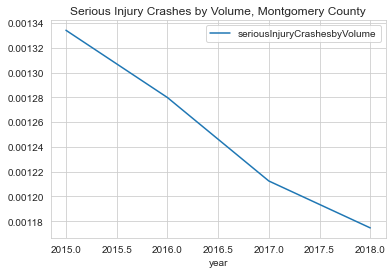

In [78]:
moCo.plot(x = 'year', y='seriousInjuryCrashesbyVolume')
plt.title("Serious Injury Crashes by Volume, Montgomery County")

(array([1., 0., 1., 0., 0., 0., 1., 0., 0., 1.]),
 array([0.00117455, 0.00119051, 0.00120647, 0.00122242, 0.00123838,
        0.00125433, 0.00127029, 0.00128625, 0.0013022 , 0.00131816,
        0.00133412]),
 <BarContainer object of 10 artists>)

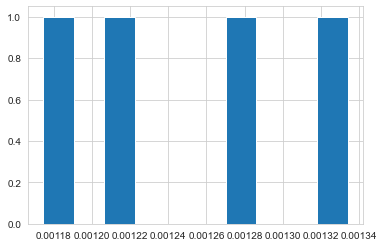

In [79]:
plt.hist(moCo['seriousInjuryCrashesbyVolume'])

Text(0.5, 1.0, 'Serious Injury Crashes by Volume, Montgomery County')

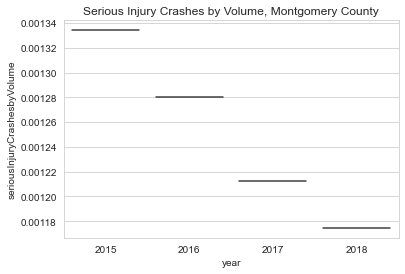

In [80]:
sns.violinplot(x='year', y='seriousInjuryCrashesbyVolume', data=moCo)
plt.title("Serious Injury Crashes by Volume, Montgomery County")

Text(0.5, 1.0, "Serious Injury Crashes by Volume, Prince George's County")

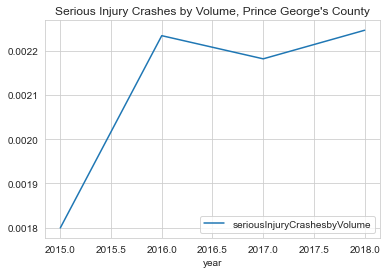

In [81]:
pgCo.plot(x = 'year', y='seriousInjuryCrashesbyVolume')
plt.title("Serious Injury Crashes by Volume, Prince George's County")

(array([1., 0., 0., 0., 0., 0., 0., 0., 1., 2.]),
 array([0.00179959, 0.00184428, 0.00188896, 0.00193364, 0.00197832,
        0.002023  , 0.00206769, 0.00211237, 0.00215705, 0.00220173,
        0.00224642]),
 <BarContainer object of 10 artists>)

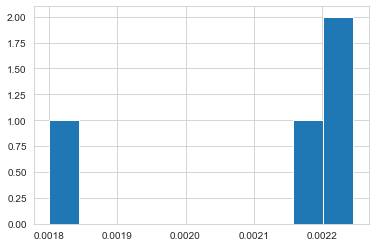

In [82]:
plt.hist(pgCo['seriousInjuryCrashesbyVolume'])

<AxesSubplot:xlabel='year', ylabel='seriousInjuryCrashesbyVolume'>

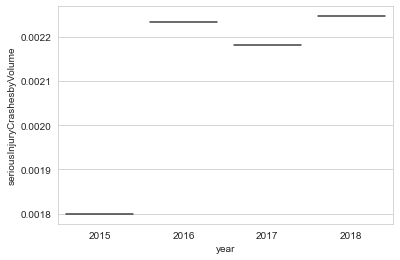

In [83]:
sns.violinplot(x='year', y="seriousInjuryCrashesbyVolume", data=pgCo)

Text(0.5, 1.0, 'Serious Injury Crashes by Volume, Frederick County')

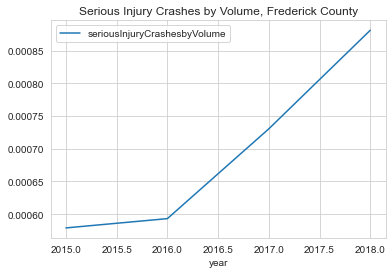

In [84]:
fredCo.plot(x='year', y = 'seriousInjuryCrashesbyVolume')
plt.title("Serious Injury Crashes by Volume, Frederick County")

(array([2., 0., 0., 0., 0., 1., 0., 0., 0., 1.]),
 array([0.00057895, 0.00060915, 0.00063935, 0.00066955, 0.00069975,
        0.00072996, 0.00076016, 0.00079036, 0.00082056, 0.00085077,
        0.00088097]),
 <BarContainer object of 10 artists>)

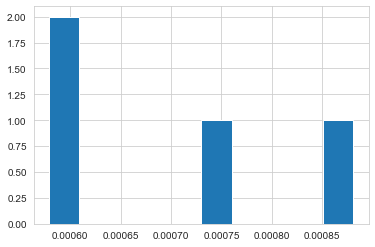

In [85]:
plt.hist(fredCo['seriousInjuryCrashesbyVolume'])

<AxesSubplot:xlabel='year', ylabel='seriousInjuryCrashesbyVolume'>

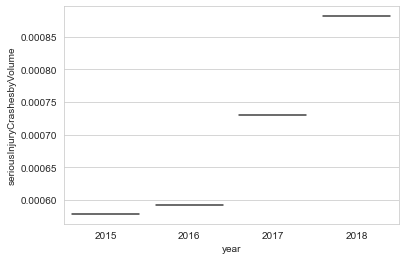

In [86]:
sns.violinplot(x='year', y='seriousInjuryCrashesbyVolume', data=fredCo)

Text(0.5, 1.0, 'Fatal Crashes by Volume, Montgomery County')

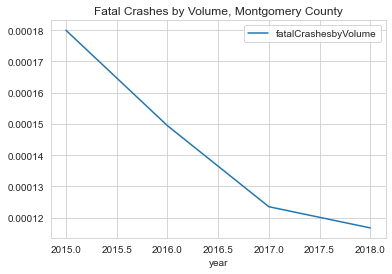

In [87]:
moCo.plot(x = 'year', y='fatalCrashesbyVolume')
plt.title("Fatal Crashes by Volume, Montgomery County")

Text(0.5, 1.0, 'Fatal Crashes by Volume, Montgomery County')

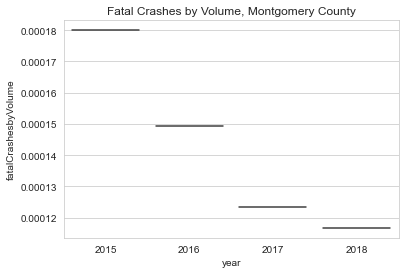

In [88]:
sns.violinplot(x='year', y='fatalCrashesbyVolume', data=moCo)
plt.title("Fatal Crashes by Volume, Montgomery County")

(array([1., 1., 0., 0., 0., 1., 0., 0., 0., 1.]),
 array([0.0001167 , 0.00012303, 0.00012936, 0.00013568, 0.00014201,
        0.00014834, 0.00015466, 0.00016099, 0.00016732, 0.00017364,
        0.00017997]),
 <BarContainer object of 10 artists>)

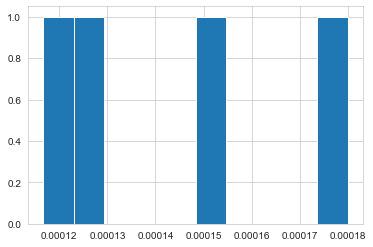

In [89]:
plt.hist(moCo['fatalCrashesbyVolume'])

Text(0.5, 1.0, "Fatal Crashes by Volume, Prince George's County")

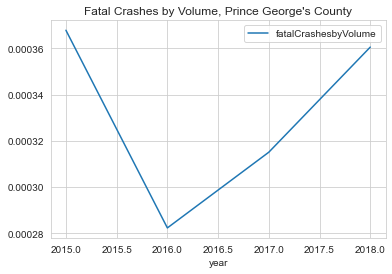

In [90]:
pgCo.plot(x = 'year', y='fatalCrashesbyVolume')
plt.title("Fatal Crashes by Volume, Prince George's County")

Text(0.5, 1.0, "Fatal Crashes by Volume, Prince George's County")

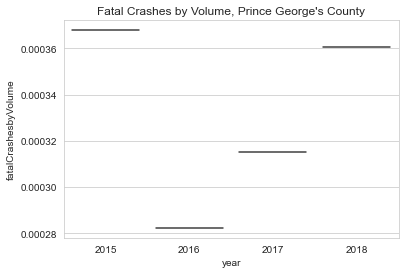

In [91]:
sns.violinplot(x='year', y='fatalCrashesbyVolume', data=pgCo)
plt.title("Fatal Crashes by Volume, Prince George's County")


(array([1., 1., 0., 0., 0., 1., 0., 0., 0., 1.]),
 array([0.0001167 , 0.00012303, 0.00012936, 0.00013568, 0.00014201,
        0.00014834, 0.00015466, 0.00016099, 0.00016732, 0.00017364,
        0.00017997]),
 <BarContainer object of 10 artists>)

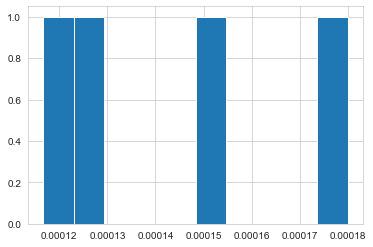

In [92]:
plt.hist(moCo['fatalCrashesbyVolume'])

Text(0.5, 1.0, 'Fatal Crashes by Volume, Frederick County')

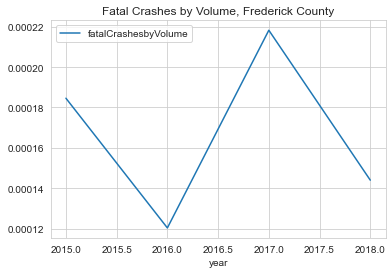

In [93]:
fredCo.plot(x = 'year', y='fatalCrashesbyVolume')
plt.title("Fatal Crashes by Volume, Frederick County")

Text(0.5, 1.0, 'Fatal Crashes by Volume, Frederick County')

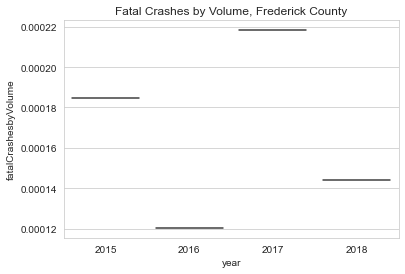

In [94]:
sns.violinplot(x='year', y='fatalCrashesbyVolume', data=fredCo)
plt.title("Fatal Crashes by Volume, Frederick County")

(array([1., 0., 1., 0., 0., 0., 1., 0., 0., 1.]),
 array([0.00012035, 0.00013014, 0.00013993, 0.00014972, 0.00015951,
        0.00016931, 0.0001791 , 0.00018889, 0.00019868, 0.00020847,
        0.00021827]),
 <BarContainer object of 10 artists>)

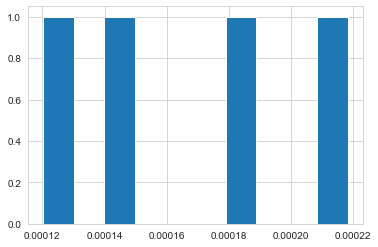

In [95]:
plt.hist(fredCo['fatalCrashesbyVolume'])

pd.crosstab('fatalCrashesbyVolume', 'location')

### One way Anova looking at crash *rates*

In [96]:
modelFatalityRates = ols('fatalCrashesbyVolume ~ C(location) ', data= trafficData).fit()
aov_table3 = sm.stats.anova_lm(modelFatalityRates, typ=2)
aov_table3

,sum_sq,df,F,PR(>F)
C(location),8.457230e-08,2.0,29.328433,0.000114
Residual,1.297633e-08,9.0,NaN,NaN


In [97]:
# source:  https://www.pythonfordatascience.org/anova-python/

"""
The function below was created specifically for the one-way ANOVA table results returned for Type II sum of squares
"""

def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']

    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])

    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])

    cols = ['sum_sq', 'df', 'mean_sq', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

anova_table(aov_table3)

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
C(location),8.457230e-08,2.0,4.228615e-08,29.328433,0.000114,0.866976,0.825218
Residual,1.297633e-08,9.0,1.441814e-09,NaN,NaN,NaN,NaN


According to this Anova analysis, there is a relationship between the rate of fatal crashes and the location.  This analysis is dependent upon a regular (gaussian normal) distribution of data, and the histograms above for crashes in each county indicate this is not necessarily true.  Really, I suspect there is too little data for a conclusive statistical determination of correlation between location and crash rates.  

In [98]:
modelInjuryRates = ols('seriousInjuryCrashesbyVolume ~ C(location) ', data= trafficData).fit()
aov_table4 = sm.stats.anova_lm(modelInjuryRates, typ=2)
aov_table4

,sum_sq,df,F,PR(>F)
C(location),4.095134e-06,2.0,87.690552,0.000001
Residual,2.101492e-07,9.0,NaN,NaN


In [99]:
anova_table(aov_table4)

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
C(location),4.095134e-06,2.0,2.047567e-06,87.690552,0.000001,0.951188,0.935268
Residual,2.101492e-07,9.0,2.334992e-08,NaN,NaN,NaN,NaN


## Time Series Data Analysis

In [100]:
# Create a dataset with numerical values for types of crash by day
moCoTS = moCoDetails[['crash_date_time_x', 'acrs_report_type_x']]

In [101]:
acrs_type = pd.get_dummies(moCoTS['acrs_report_type_x'])

In [102]:
moCoTS = pd.concat([moCoTS, acrs_type], axis = 1)

In [103]:
moCoTS = moCoTS.drop(columns = ['acrs_report_type_x'])
moCoTS = moCoTS.rename(columns = {'crash_date_time_x': 'date_time'})

In [104]:
moCoTS

,date_time,Fatal Crash,Injury Crash,Property Damage Crash
0,2020-05-02 14:16:00,0,0,1
1,2020-09-15 15:33:00,0,1,0
2,2020-09-15 15:33:00,0,1,0
3,2020-10-14 08:40:00,0,0,1
4,2020-03-03 09:19:00,0,0,1
...,...,...,...,...
122554,2021-03-08 14:15:00,0,0,1
122555,2021-03-08 14:15:00,0,0,1
122556,2021-03-08 14:15:00,0,0,1
122557,2021-03-17 21:15:00,0,0,1


In [105]:
moCoTS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122559 entries, 0 to 122558
Data columns (total 4 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   date_time              122558 non-null  datetime64[ns]
 1   Fatal Crash            122559 non-null  uint8         
 2   Injury Crash           122559 non-null  uint8         
 3   Property Damage Crash  122559 non-null  uint8         
dtypes: datetime64[ns](1), uint8(3)
memory usage: 1.3 MB


In [106]:
moCoTS.rename(columns={'Fatal Crash': 'Fatal_Crash', 'Injury Crash': 'Injury_Crash', 'Property Damage Crash':
                      'Property_Damage_Crash'}, inplace=True)
moCoTS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122559 entries, 0 to 122558
Data columns (total 4 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   date_time              122558 non-null  datetime64[ns]
 1   Fatal_Crash            122559 non-null  uint8         
 2   Injury_Crash           122559 non-null  uint8         
 3   Property_Damage_Crash  122559 non-null  uint8         
dtypes: datetime64[ns](1), uint8(3)
memory usage: 1.3 MB


In [107]:
moCoTS.groupby('date_time')
moCoTS

,date_time,Fatal_Crash,Injury_Crash,Property_Damage_Crash
0,2020-05-02 14:16:00,0,0,1
1,2020-09-15 15:33:00,0,1,0
2,2020-09-15 15:33:00,0,1,0
3,2020-10-14 08:40:00,0,0,1
4,2020-03-03 09:19:00,0,0,1
...,...,...,...,...
122554,2021-03-08 14:15:00,0,0,1
122555,2021-03-08 14:15:00,0,0,1
122556,2021-03-08 14:15:00,0,0,1
122557,2021-03-17 21:15:00,0,0,1


In [108]:
# Create time series readable by fbprophet

tsFatalities = pd.DataFrame({'ds':moCoTS.date_time,'y':moCoTS.Fatal_Crash})

In [109]:
tsFatalities.head()

,ds,y
0,2020-05-02 14:16:00,0
1,2020-09-15 15:33:00,0
2,2020-09-15 15:33:00,0
3,2020-10-14 08:40:00,0
4,2020-03-03 09:19:00,0


In [110]:
tsFatalities.isna().sum()

ds    1
y     0
dtype: int64

In [111]:
tsFatalities = tsFatalities.dropna()

In [112]:
# instantiate the model and fit the timeseries

prophet1 = Prophet()
prophet1.fit(tsFatalities)

In [113]:
# create a future data frame 
future = prophet1.make_future_dataframe(periods=25)
forecast = prophet1.predict(future)

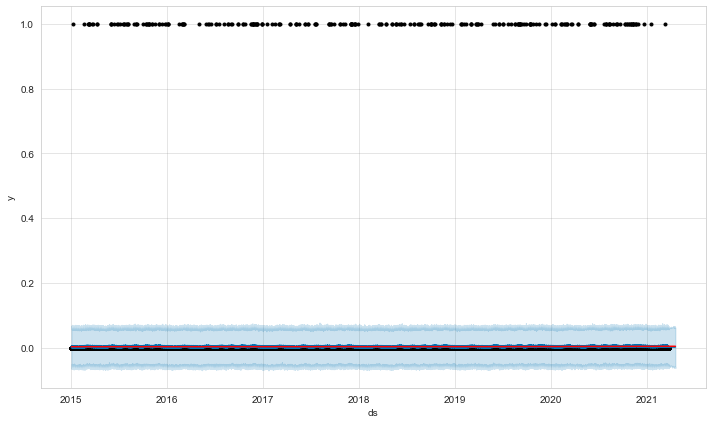

In [114]:
# display the most critical output columns from the forecast
forecast[['ds','yhat','yhat_lower','yhat_upper']].head()

# plot
fig = prophet1.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet1, forecast)


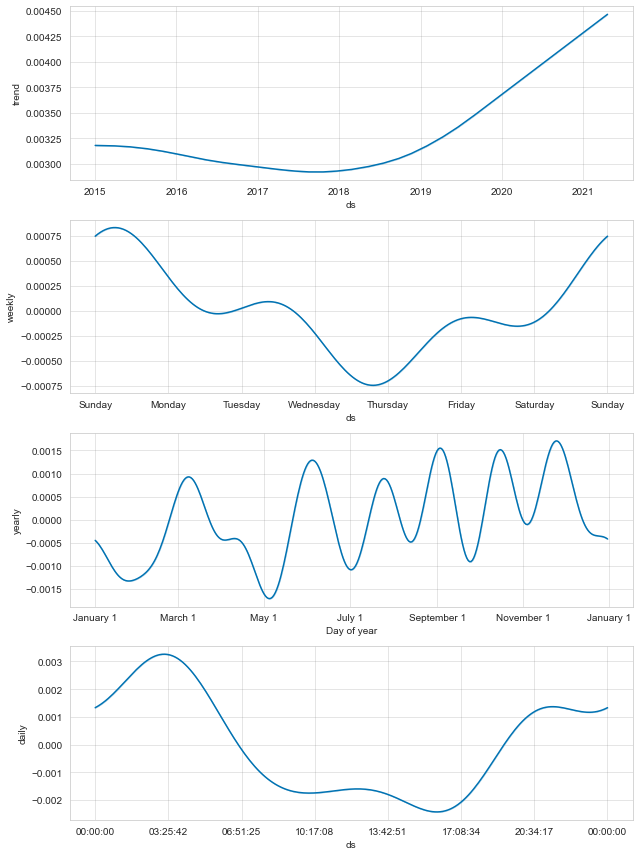

In [115]:
fig3 = prophet1.plot_components(forecast)



In [116]:
# Repeat the process for injuries

tsInjuries = pd.DataFrame({'ds':moCoTS.date_time,'y':moCoTS.Injury_Crash})

In [117]:
tsInjuries.head()

,ds,y
0,2020-05-02 14:16:00,0
1,2020-09-15 15:33:00,1
2,2020-09-15 15:33:00,1
3,2020-10-14 08:40:00,0
4,2020-03-03 09:19:00,0


In [118]:
tsInjuries.isna().sum()

ds    1
y     0
dtype: int64

In [119]:
# There is only one NA in over 120000 entries, so I'll just drop it

tsInjuries = tsInjuries.dropna()

In [120]:
# instantiate the model and fit the timeseries

prophet2 = Prophet()
prophet2.fit(tsInjuries)

In [121]:
# create a future data frame 
future2 = prophet2.make_future_dataframe(periods=25)
forecast2 = prophet2.predict(future2)

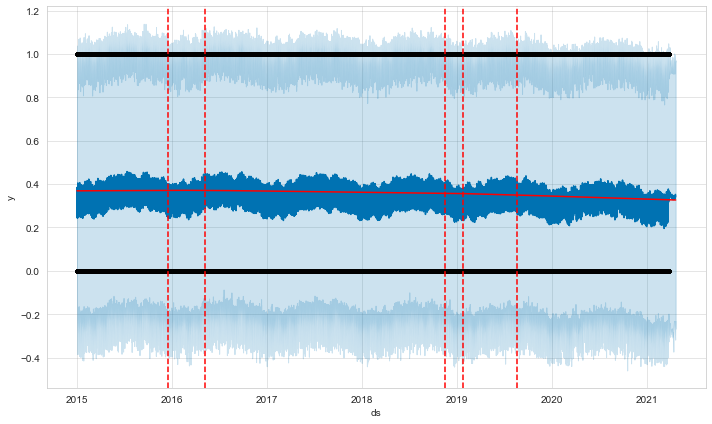

In [122]:
# display the most critical output columns from the forecast
forecast2[['ds','yhat','yhat_lower','yhat_upper']].head()

# plot
fig2 = prophet2.plot(forecast2)
a2 = add_changepoints_to_plot(fig2.gca(), prophet2, forecast2)

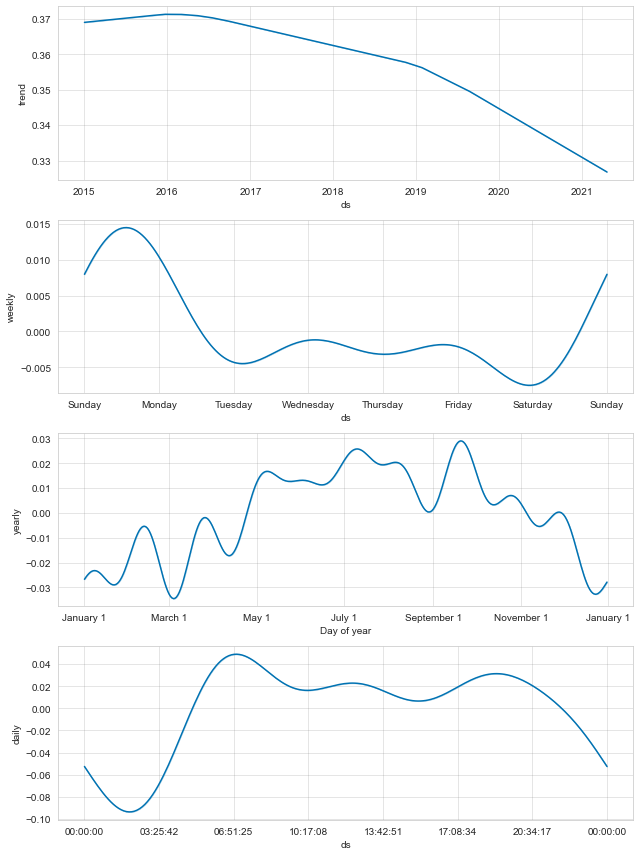

In [123]:
fig4 = prophet2.plot_components(forecast2)

## Time Series Analysis of Maryland Data



In [124]:
# Set year to datetime

trafficData['year'] = pd.to_datetime(trafficData['year'])

In [125]:
moCo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 9
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   year                          4 non-null      int64  
 1   fatal_crashes                 4 non-null      int64  
 2   serious_injury_crashes        4 non-null      int64  
 3   location                      4 non-null      object 
 4   population                    4 non-null      int64  
 5   traffic_volume                4 non-null      float64
 6   fatalCrashesbyVolume          4 non-null      float64
 7   seriousInjuryCrashesbyVolume  4 non-null      float64
dtypes: float64(3), int64(4), object(1)
memory usage: 460.0+ bytes


In [126]:
tsMoCo = pd.DataFrame({'ds':moCo.year,'y':moCo.fatal_crashes})

In [127]:
prophet3 = Prophet()

In [128]:
prophet3.fit(tsMoCo)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 2.


In [129]:
# create a future data frame 
future3 = prophet3.make_future_dataframe(periods=25)
forecast3 = prophet3.predict(future3)